# Goal 1: Planck-Like likelihood

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'
%env OMP_NUM_THREADS=20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: OMP_NUM_THREADS=20


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
fiducial_params = {
    'omega_b': 0.0224, 'omega_cdm': 0.12, 
    '100*theta_s': 1.0416, 'tau_reio': 0.07,
    'A_s': 2.2e-9, 'n_s': 0.96,
    'N_ur': 2.0328, 'N_ncdm': 1, 'm_ncdm': 0.06, 'T_ncdm': 0.71611,}

l_max = 2500

modules_path = '/home/zequnl/src/cobaya_modules'

info_fiducial = {
    'params': fiducial_params,
    'likelihood': {'one': None},
    'theory': {
        'classy': None
        
    }
}

from cobaya.model import get_model
model_fiducial = get_model(info_fiducial)

# Declare our desired theory product
# (there is no cosmological likelihood doing it for us)
model_fiducial.likelihood.theory.needs(Cl={'tt': l_max})

# Compute and extract the CMB power spectrum
# (In muK^-2, without l(l+1)/(2pi) factor)
# notice the empty dictionary below: all parameters are fixed
model_fiducial.logposterior({})
Cls = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)

# Our fiducial power spectrum
Cl_est = Cls['tt'][:l_max+1]

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[classy] Importing *global* CLASS.


In [7]:
import fishchips

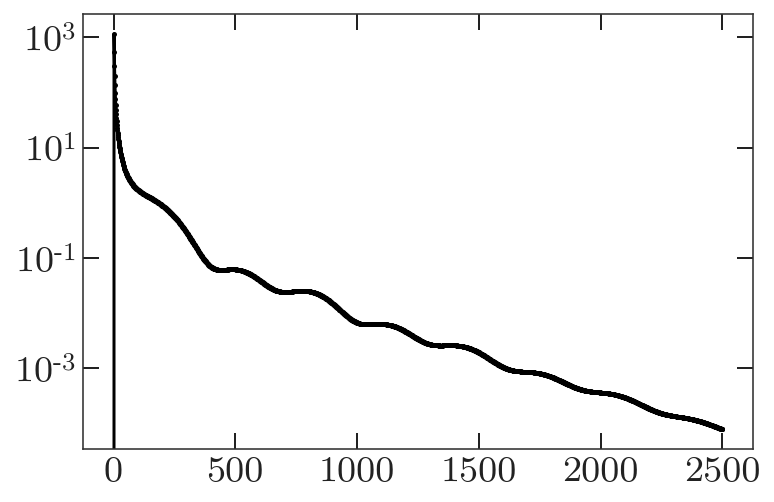

In [8]:
plt.plot(Cl_est)
plt.yscale('log')

In [9]:
from collections import defaultdict

def δ(α, β):
    return np.array(α==β, dtype=float)

def cov_2pt(signal_dict, noise_dict, bin_left, bin_right=None, 
            f_sky=0.6, N_splits=2,
            instruments=('Planck', 'Planck', 'Planck', 'Planck'), 
            observables=('T', 'T', 'T', 'T'), 
            seasons=(0,0,0,0),
            verbose=True):
    """Compute a covariance matrix for a 2-pt correlation function.
    
    This is an implementation of equation B2 in arXiv:1610.02360.
    
    signal_dict : dict
        Must have tuple keys for all two-point (T/E/B/κ) pairs
        i.e. a key could be ('T', 'E').
    noise_dict : dict
        Must have tuple keys in the format
            (season, instrument, season, instrument, T/E/B/κ, T/E/B/κ)
        If you have only one season, set every season value to 0.
    """
    
    # if bin_right is not specified, bin_right[n] = bin_left[n+1]
    if bin_right == None: 
        Δbin = bin_left[-1] - bin_left[-2] # last bin-width
        bin_right = np.hstack((np.array(bin_left[1:]), [bin_left[-1]+Δbin]))
        
    A, B, C, D = instruments
    W, X, Y, Z = observables
    α, β, γ, τ = seasons
    
    N_s = N_splits
    n_b = len(bin_left)
    
    # assume zero signal and infinite noise for non-specified terms
    S_b = defaultdict(lambda:0.0, signal_dict)
    N_b = defaultdict(lambda:np.inf, noise_dict)
    
    ν_b = np.zeros(n_b)
    for i, (bl, br) in enumerate(zip(bin_left, bin_right)):
        ν_b[i] = np.sum(2 * np.arange(bl, br) + 1) * f_sky
    
    # deliberately not PEP8, I think this is more readable
    sum1 = S_b[W,Y] * S_b[X,Z] + S_b[W,Z] * S_b[X,Y]
    
    sum2 = (
        S_b[W,Y] * δ(β,τ) * N_b[β,B,τ,D,X,Z] + 
        S_b[X,Z] * δ(α,γ) * N_b[α,A,γ,C,W,Y] +
        S_b[W,Z] * δ(β,γ) * N_b[β,B,γ,C,X,Y] + 
        S_b[X,Y] * δ(α,τ) * N_b[α,A,τ,D,W,Z]
    )
    
    sum3 = (
        δ(α,γ) * δ(β,τ) * N_b[α,A,γ,C,W,Y] * N_b[β,B,τ,D,X,Z] +
        δ(β,γ) * δ(α,τ) * N_b[α,A,τ,D,W,Z] * N_b[β,B,γ,C,X,Y]
    )
    
    prefactor_3 = (1/ν_b) * (
        (N_s**2 - N_s * (δ(α,β) + δ(γ,τ)) + N_s * δ(α,β) * δ(γ,τ)) /
        (N_s**4 - N_s**3 * (δ(α,β) + δ(γ,τ)) + N_s**2 * δ(α,β) * δ(γ,τ))
    )
    
    return (1/ν_b) * sum1 + (1/(N_s * ν_b)) * sum2 + prefactor_3 * sum3

We compute the likelihood, 

$$ -2 \ln L = (C^{th} - C)^T \mathbf{\Sigma}^{-1} (C^{th} - C) + \ln \det \mathbf{\Sigma}$$

In [12]:

import fishchips.experiments

def my_like(
        # Parameters that we may sample over (or not)
#         beam_FWHM=0.1,  # deg
        # Declaration of our theory requirements
        _theory={'Cl': {'tt': l_max}},
        # Declaration of available derived parameters
        _derived={}):
    
    Nltt = fishchips.experiments.CMB_Primary(l_max=l_max).noise_T
    Cltt = _theory.get_Cl(ell_factor=False)['tt'][:l_max+1]
    Clee = _theory.get_Cl(ell_factor=False)['ee'][:l_max+1]
    
    covTTTT = cov_2pt(
        {('T', 'T'): Cltt},
        {(0, 'Planck', 0, 'Planck', 'T', 'T'): Nltt},
        bin_left=np.arange(l_max+1),
        observables=('T', 'T', 'T', 'T'), 
        
        instruments=('Planck', 'Planck', 'Planck', 'Planck'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    
    covEEEE = cov_2pt(
        {('E', 'E'): Clee},
        {(0, 'Planck', 0, 'Planck', 'E', 'E'): Nlee},
        bin_left=np.arange(l_max+1),
        observables=('E', 'E', 'E', 'E'), 
        
        instruments=('Planck', 'Planck', 'Planck', 'Planck'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    
    # compute difference between model and data vectors
    diff_vec = Cltt - Cl_est  # Cl_est is fiducial (i.e. data in the forecasting case)
    # now that we have Sigma, compute the equation above
    invcov = np.diag( 1 / cov )
    ptemp = np.dot(invcov, diff_vec)
    like = np.sum(ptemp * diff_vec)

    return -(like + np.sum(np.log(cov))) / 2.0

In [13]:
my_like(_theory=model_fiducial.likelihood.theory)
# plt.yscale('log')

19045.99121259802

In [9]:
info = {
    'params': {
        # Fixed
        'N_ur': 2.0328, 'N_ncdm': 1, 'm_ncdm': 0.06, 'T_ncdm': 0.71611,
        # Sampled
        
        'logA': {
            'prior': {'min': 1.61, 'max': 3.91}, 
            'ref' : {'dist' : 'norm', 'loc' : 3.05, 'scale' : 0.001},
            'proposal' : 0.001,
            'latex': '\log(10^{10} A_\mathrm{s})', 
            'drop': True
        },
        'n_s': {
            'prior': {'min': 0.9, 'max': 1.1}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.965, 'scale' : 0.004},
            'proposal' : 0.002,
            'latex': 'n_s'
        },
        'omega_b': {
            'prior': {'min': 0.005, 'max': 0.1}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.0224, 'scale' : 0.0001},
            'proposal' : 0.0001,
            'latex': '\Omega_\mathrm{b} h^2'
        },
        'omega_cdm': {
            'prior': {'min': 0.001, 'max': 0.99}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.12, 'scale' : 0.001},
            'proposal' : 0.0005,
            'latex': '\Omega_\mathrm{c} h^2'
        },
        'theta_s_1e2' : {
            'prior': {'min': 0.5, 'max': 10.0}, 
            'ref' : {'dist' : 'norm', 'loc' : 1.0416, 'scale' : 0.0004},
            'proposal' : 0.0002,
            'latex': '100\theta_\mathrm{s}', 
            'drop': True
        },
        '100*theta_s' : {
            'value': 'lambda theta_s_1e2: theta_s_1e2',
            'derived': False
        },
        'tau_reio': {
            'prior': {'min': 0.01, 'max': 0.08}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.055, 'scale' : 0.006},
            'proposal' : 0.003,
            'latex': '\tau_\mathrm{reio}'
        },
        # Derived
        
        'A_s': {'value':'lambda logA: 1e-10*np.exp(logA)', 'latex': 'A_s'},
        'H0' : {'latex':'H_0'},
        
    },
    'likelihood': {'my_cl_like': my_like},
    'theory': {'classy' : None},
    'sampler': {
        'mcmc': {
            'covmat' : 'class_bluebook.covmat',
            'proposal_scale' : 2.4
        }
    },
#     'sampler': {
#         'polychord': None
#     },  # or polychord...

    'resume' : True,
#     'force' : True,
    
#     'modules': modules_path,
    'output': 'chains/class_bluebook'}

In [10]:
from cobaya.model import get_model
model = get_model(info)

[model] *WARNING* Ignored blocks/options: ['sampler', 'resume', 'output']
[my_cl_like] Initialised external likelihood.
[classy] Importing *global* CLASS.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['H0', 'Cl']


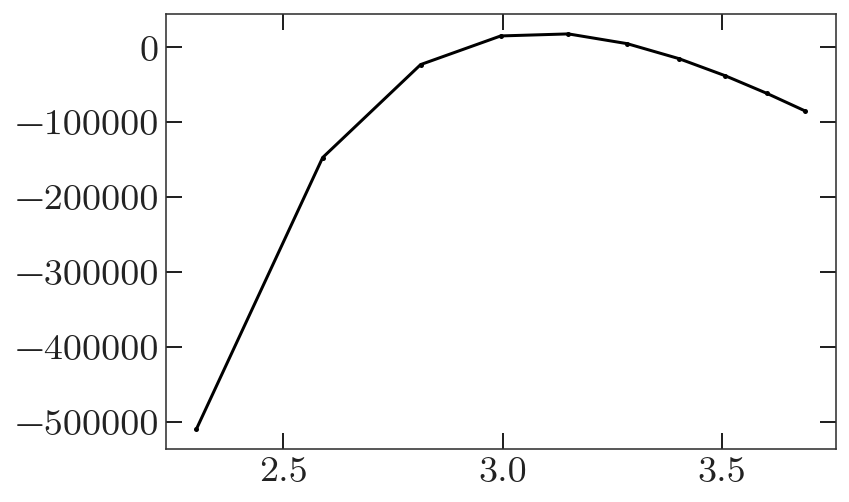

In [11]:
As = np.log(1e10 * np.linspace(1e-9, 4e-9, 10))

par = fiducial_params.copy()
del par['100*theta_s']
del par['A_s']
likes = [model.loglike({**par, **{'logA': A,
                                 'theta_s_1e2':1.042}})[0] for A in As]

plt.figure()
plt.plot(As, likes)
plt.show()

In [ ]:
from cobaya.run import run
updated_info, products = run(info)

[output] Output to be read-from/written-into folder 'chains', with prefix 'class_bluebook'
[output] Found existing products with the requested ouput prefix: 'chains/class_bluebook'
[output] Let's try to resume/load.
[my_cl_like] Initialised external likelihood.
[classy] Importing *global* CLASS.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['H0', 'Cl']
[mcmc] Resuming from previous sample!
[1] Loaded sample from 'chains/class_bluebook.1.txt'
[mcmc] Covariance matrix from checkpoint.
[mcmc] Initial point:
[mcmc] 
 weight  minuslogpost      logA       n_s   omega_b  omega_cdm  theta_s_1e2  tau_reio           A_s        H0  \
    1.0    -19050.327  3.091339  0.969817  0.022335   0.117685      1.04107  0.076281  2.200653e-09  67.89867   

 minuslogprior  minuslogprior__0       chi2  chi2__my_cl_like  
     -3.549436         -3.549436 -38093.555        -38093.555  
[mcmc] Sampling! (NB: nothing will be printed until 120 burn-in samples have

/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/cobaya/samplers/mcmc/mcmc.py:320: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  initial_point = (self.collection[self.collection.sampled_params]
/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/cobaya/samplers/mcmc/mcmc.py:322: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  logpost = -(self.collection[_minuslogpost]
/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/cobaya/samplers/mcmc/mcmc.py:324: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.py

[mcmc] Finished burn-in phase: discarded 120 accepted steps.
[mcmc] Checkpoint: 240 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Convergence of means: R-1 = 1.158851 after 240 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 480 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Convergence of means: R-1 = 1.435544 after 480 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 720 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Convergence of means: R-1 = 0.489294 after 720 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.


In [14]:
from getdist import loadMCSamples

# gd_sample = MCSamplesFromCobaya(updated_info, products["sample"])
gd_sample = loadMCSamples("chains/class_bluebook")

In [15]:
gd_sample.paramNames.setLabels(['logA', 'n_s',r'\omega_b',r'\omega_{cdm}',r'100 \theta_S',r'\tau_{reio}','A_s','H_0'])

Mean:
[3.04131162 0.95609154]
Covariance matrix:
[[1.62782304e-03 7.54603816e-05]
 [7.54603816e-05 9.92823619e-05]]


[root] *WARNING* 2D kernel density bandwidth optimizer failed for theta_s_1e2, tau_reio. Using fallback width.


[root] *WARNING* 2D kernel density bandwidth optimizer failed for tau_reio, A_s. Using fallback width.


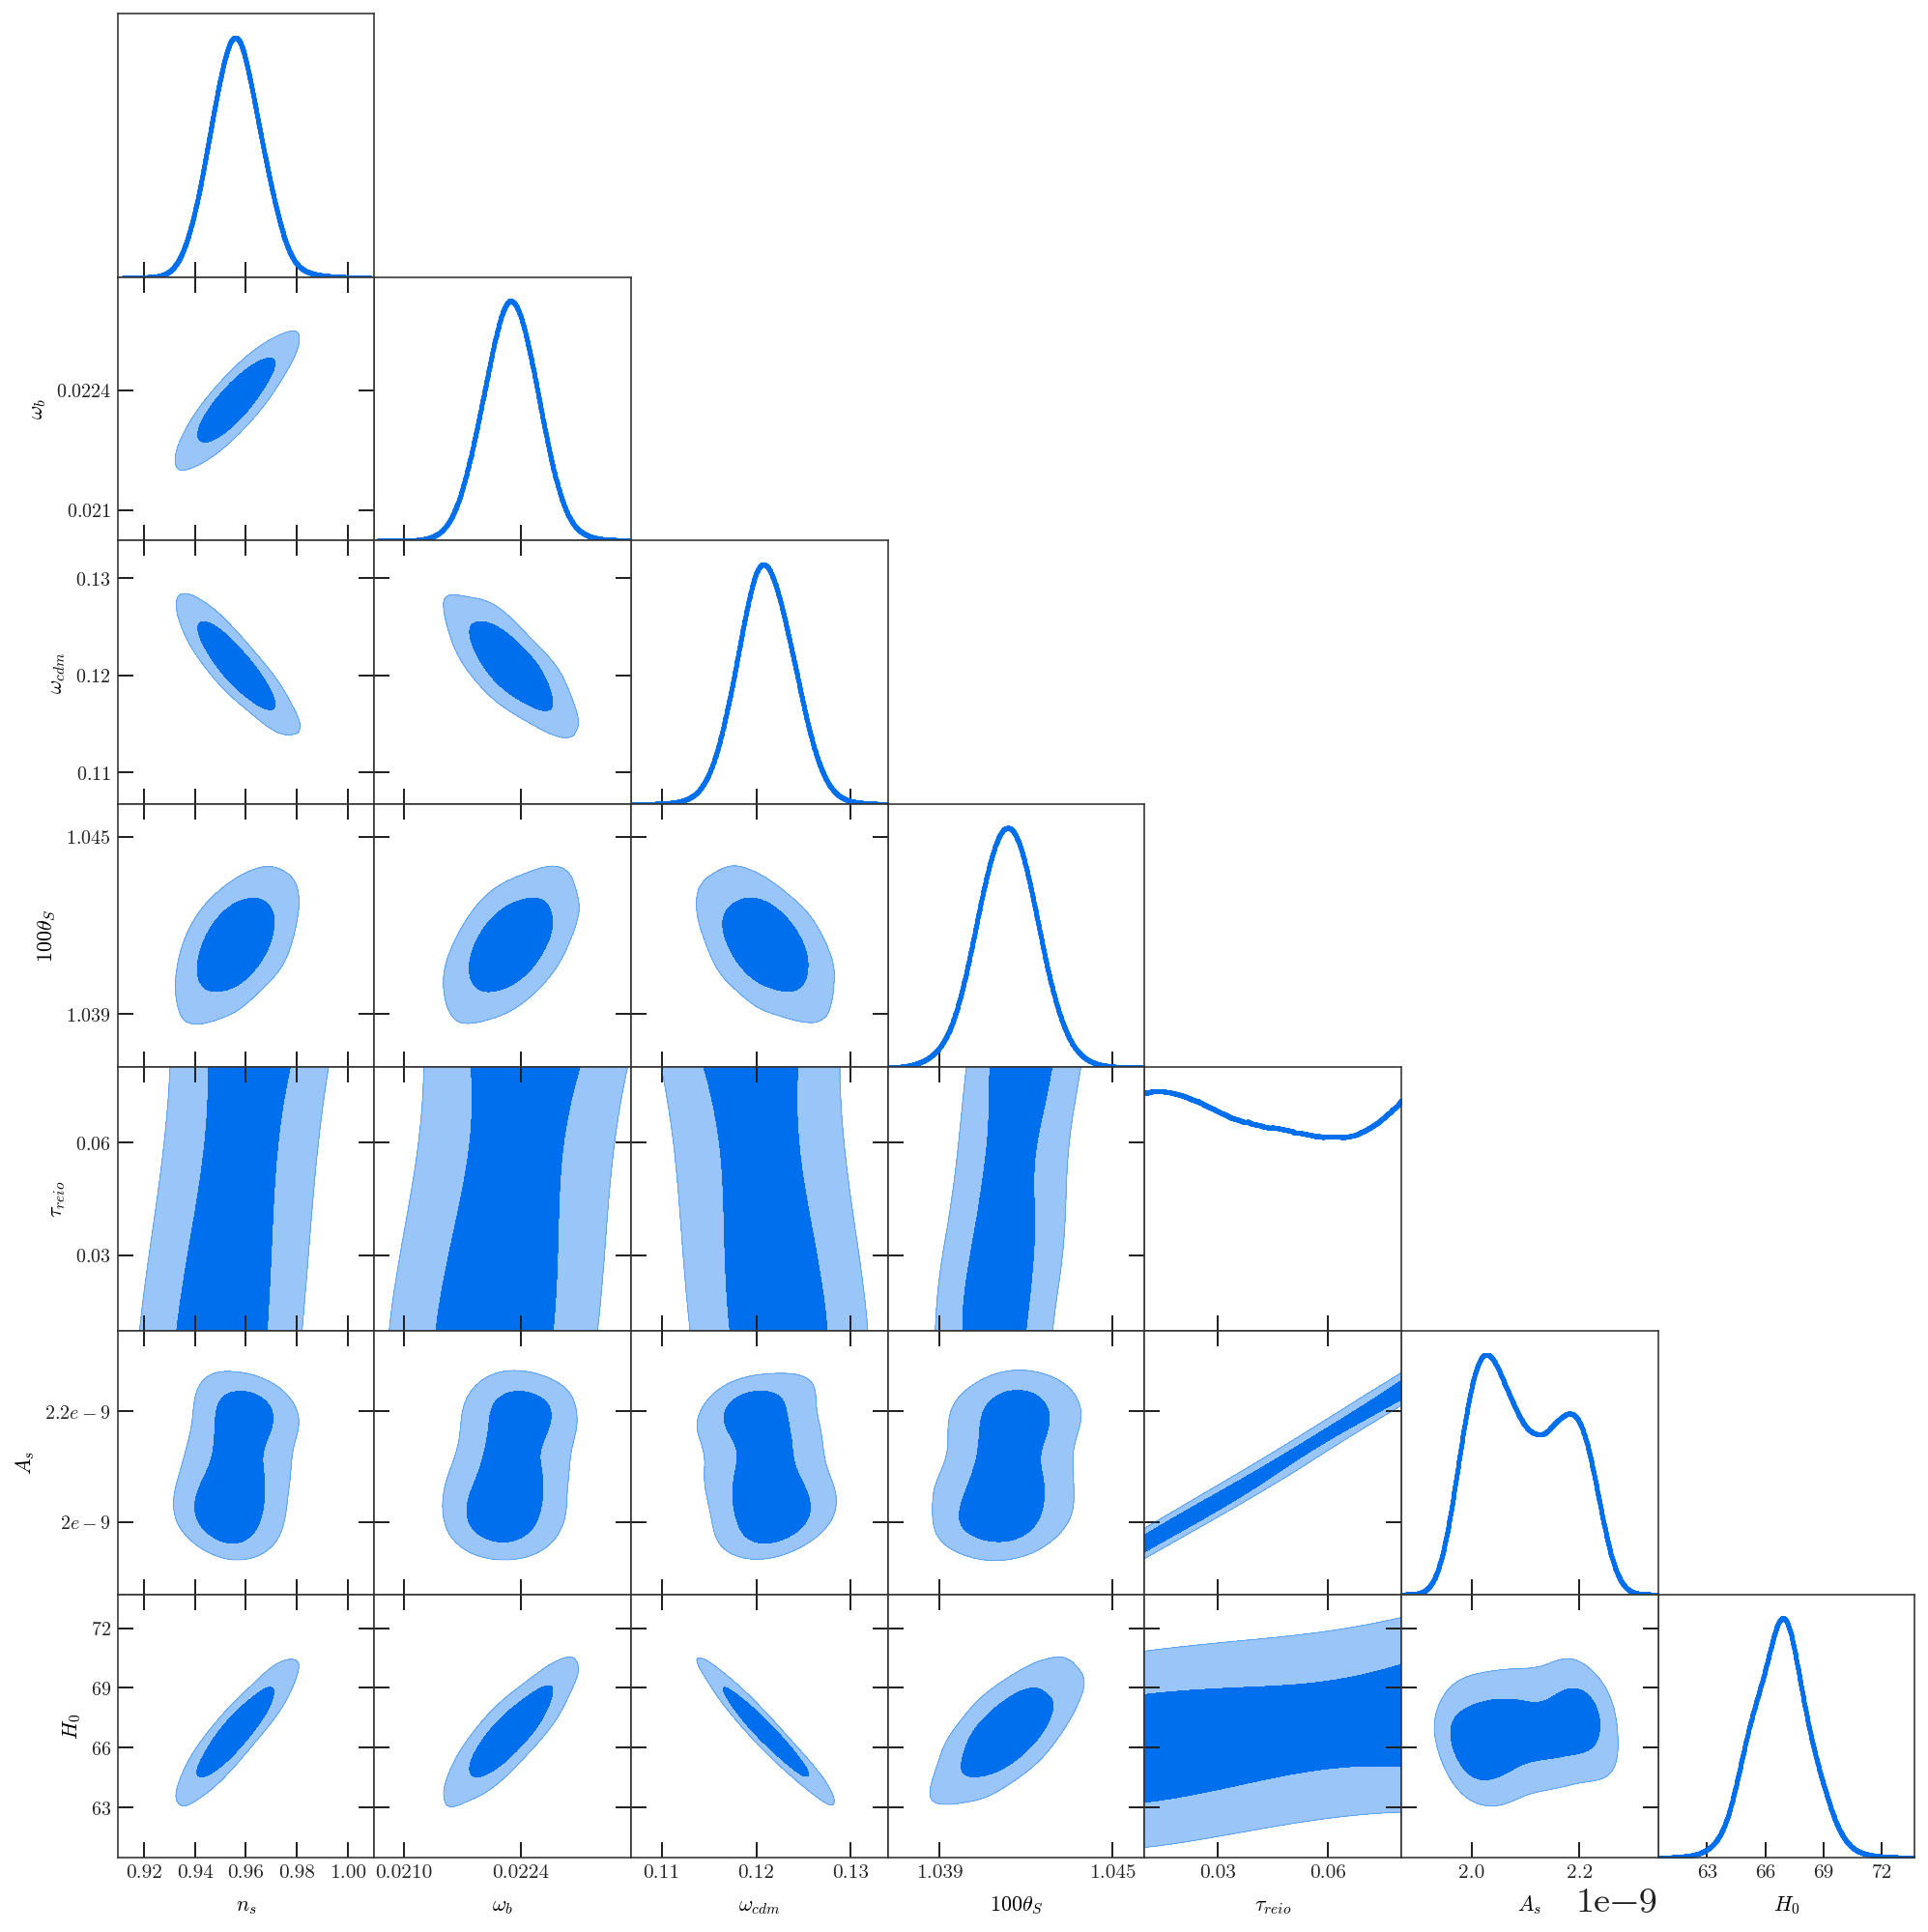

In [16]:
# Export the results to GetDist
# Analyze and plot
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)

%matplotlib inline
import getdist.plots as gdplt
gdplot = gdplt.getSubplotPlotter()
gdplot.triangle_plot(gd_sample, ['n_s','omega_b','omega_cdm','theta_s_1e2','tau_reio','A_s','H0'], filled=True)